In [1]:
%load_ext autoreload
%autoreload

In [2]:
from matplotlib import pyplot
import numpy as np
import os
os.environ['NUMBA_DISABLE_JIT'] = '1'

In [3]:
from pystrict import strict
import numpy as np
from PySDM.physics.constants import si
from PySDM.initialisation.spectra import Gamma
from PySDM.dynamics.collisions.collision_kernels import Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import Feingold1988Frag, ExponFrag, AlwaysN
from PySDM.formulae import Formulae
from PySDM.physics.constants_defaults import rho_w


In [12]:
@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**8
        self.n_part = 1e4 / si.cm**3
        self.theta = 0.33e-9 * si.g / rho_w
        self.k = 1
        self.dv = 1 * si.cm**3
        self.norm_factor = self.n_part * self.dv
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [i for i in range(60)] #[0, 60]
        self.kernel = Golovin(b=2000 * si.cm**3 / si.g / si.s * rho_w)
        #self.kernel = Golovin(b=20000 * si.cm**3 / si.g / si.s * rho_w)
        self.coal_effs = [ConstEc(Ec=0.8), ConstEc(Ec=0.9),ConstEc(Ec=1.0)]
        self.rho = rho_w
        self.vmin = 0.1*si.um**3
        self.fragtol = 1e-3
        self.fragmentation = Feingold1988Frag(scale=self.k * self.theta / 2, fragtol=self.fragtol, 
                                            vmin=self.vmin, nfmax=20)
        #self.fragmentation = ExponFrag(scale=self.k*self.theta/2)
        #self.fragmentation = AlwaysN(n=2)
        self.break_eff = ConstEb(1.0) # no "bouncing"
        self.spectrum = Gamma(norm_factor=self.norm_factor, k=self.k, theta=self.theta)
        # self.radius_bins_edges = np.logspace(
        #     np.log10(1 * si.um),
        #     np.log10(1000 * si.um),
        #     num=128, endpoint=True
        # )
        # self.radius_range = [0 * si.um, 1e6 * si.um]


    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

In [13]:
from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
import PySDM.products.size_spectral.arbitrary_moment as am

In [14]:
settings = Settings()
coal_eff = ConstEc(Ec=0.8)
backend = CPU
builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.0
attributes = {}
attributes['volume'], attributes['n'] = \
    ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
collision = Collision(
    settings.kernel,
    coal_eff,
    settings.break_eff,
    settings.fragmentation,
    adaptive=settings.adaptive
)
builder.add_dynamic(collision)
M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='m^3')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^3')
products = (
    M0(name='M0'),
    M1(name='M1'),
    M2(name='M2')
)
particulator = builder.build(attributes, products)

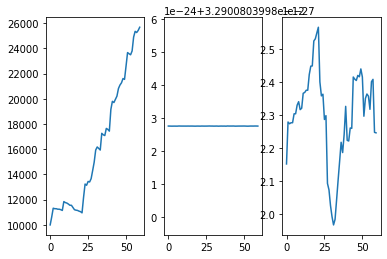

In [15]:
t = settings.output_steps
moments = np.zeros((3, len(t)))
j = 0
for step in settings.output_steps:
    particulator.run(step - particulator.n_steps)
    moments[:,j] = [particulator.products['M0'].get()[0], particulator.products['M1'].get()[0], 
        particulator.products['M2'].get()[0]]
    j += 1
    #print(particulator.attributes['n'].to_ndarray())
fig, ax = pyplot.subplots(1, 3)
ax[0].plot(t,moments[0,:])
ax[1].plot(t,moments[1,:]*moments[0,:])
ax[2].plot(t,moments[2,:]*moments[0,:])